In [223]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

#### Here, we are just making a prediction about where the dependent variable should be given the % changes in the independent variable(s)
#### The greater value we choose for p_change_t, the more likely we will overfit the model. 

In [224]:
def trainer(independents, dep, p_change_t, t):
    tickers = independents + [dep]
    df = yf.download(tickers, start=date.today() - timedelta(t), end=date.today() + timedelta(1), interval='1d')['Adj Close'].resample('D').last()
    df = df.dropna()
    for c in df.columns:
        df[f'{c}%'] = df[c].pct_change(p_change_t)
    df = df.dropna()
    model = LinearRegression()
    model.fit(df[[f'{c}%' for c in independents]], df[f'{dep}%'])
    df['predicted_dep%'] = model.predict(df[[f'{c}%' for c in independents]])
    df['predicted_dep'] = (1 + df['predicted_dep%']) * df[dep].shift(p_change_t)
    #df[[dep, 'predicted_dep']].iloc[-t:,:].plot()
    df = df[[dep, 'predicted_dep']].dropna()
    return df

data = trainer(['JPY=X', '^TNX'], '^GSPC', 25, 1000)

[*********************100%%**********************]  3 of 3 completed


### Now, we have to construct a trading strategy. Essentially, we want to take a position on the dependent variable if the value deviates too far from the value we predicted
#### - This means that we are using the spread between the observed value and the predicted value as our signal.
#### - We want to control for the volatility of whatever we choose as our dependent variable. We choose a window of returns to look back on, and select how many stds we want
#### - For example, we could say that if the spread is greater than 1std of the past 40 days, we bet that the underlying will revert to our predicted value (go short)
#### - We need to make sure to shift the signal by one day as well.
#### - Notes: The lower we set the std threshold, the more aggressively the strategy will trade. 

,observed,prediction,observed_returns,spread,spread_upper,spread_lower,signal,strategy_returns,cumulative_strategy_returns,cumulative_observed_returns
Date,,,,,,,,,,
2021-10-06,4363.549805,4471.868161,0.004103,-108.318357,65.193590,-65.193590,NaN,NaN,NaN,1.004103
2021-10-07,4399.759766,4449.249722,0.008298,-49.489957,65.569106,-65.569106,1.0,0.008298,1.008298,1.012435
2021-10-08,4391.339844,4437.833282,-0.001914,-46.493438,66.003777,-66.003777,0.0,-0.000000,1.008298,1.010498
2021-10-11,4361.189941,4444.055892,-0.006866,-82.865951,67.046767,-67.046767,0.0,-0.000000,1.008298,1.003560
2021-10-12,4350.649902,4465.390978,-0.002417,-114.741075,68.114328,-68.114328,1.0,-0.002417,1.005861,1.001134
...,...,...,...,...,...,...,...,...,...,...
2024-02-16,5005.569824,4777.136503,-0.004803,228.433321,106.674050,-106.674050,-1.0,0.004803,1.431661,1.151839
2024-02-20,4975.509766,4773.310416,-0.006005,202.199350,105.573646,-105.573646,-1.0,0.006005,1.440258,1.144922
2024-02-21,4981.799805,4774.713477,0.001264,207.086327,105.830797,-105.830797,-1.0,-0.001264,1.438437,1.146369


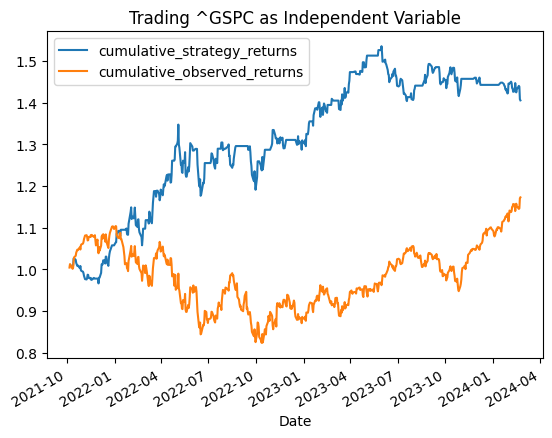

In [225]:
def trader(data, w, stds):
    df = data.copy()
    title = df.columns[0]
    df.columns = ['observed', 'prediction']
    df['observed_returns'] = df['observed'].pct_change()
    df['spread'] = df['observed'] - df['prediction']
    df['spread_upper'] = df['observed'].rolling(w).std() * stds
    df['spread_lower'] = df['spread_upper'] * -1
    df = df.dropna()
    df['signal'] = 0  
    df.loc[df['spread'] > df['spread_upper'], 'signal'] = -1
    df.loc[df['spread'] < df['spread_lower'], 'signal'] = 1
    df['signal'] = df['signal'].shift(1)
    df['strategy_returns'] = df['observed_returns'] * df['signal']
    df['cumulative_strategy_returns'] = (1 + df['strategy_returns']).cumprod()
    df['cumulative_observed_returns'] = (1 + df['observed_returns']).cumprod()
    ax = df[['cumulative_strategy_returns', 'cumulative_observed_returns']].plot()
    ax.set_title(f'Trading {title} as Independent Variable')
    return df

trader(data, 40, 1)    

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


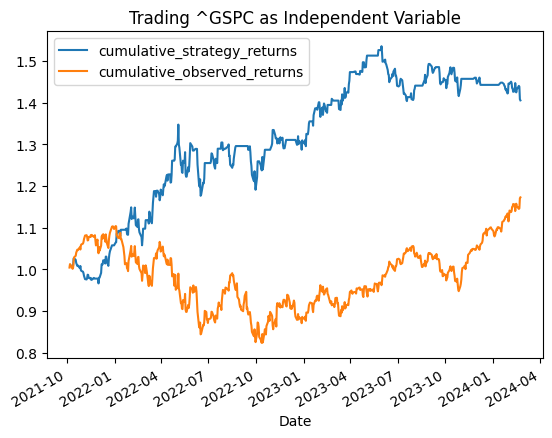

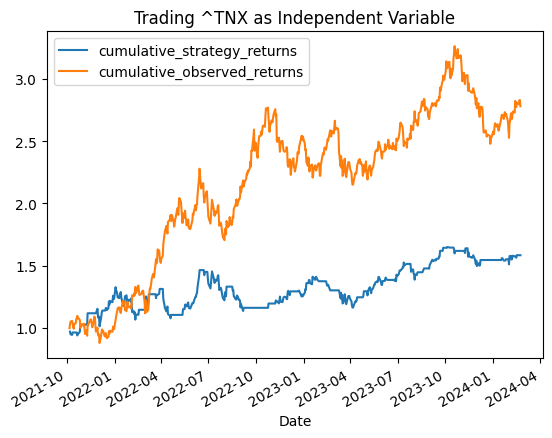

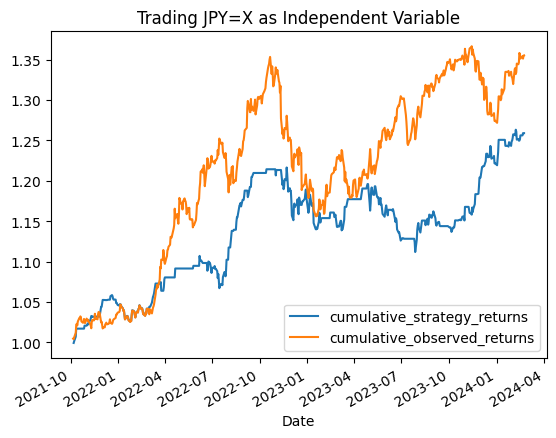

In [226]:
variables = ['^GSPC', '^TNX', 'JPY=X']
for v in variables:
    independents = [x for x in variables if x != v]
    dep = v
    trader(trainer(independents, dep, 25, 1000), 40, 1)